In [1]:
from sqlalchemy import create_engine
import pandas as pd
import os
from datetime import datetime

engine = create_engine("sqlite:///mta_project.db")

def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if len(str(row['ENTRIES'])) < len(str(row['PREV_ENTRIES']))-2:
        counter = 0
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        counter = row["PREV_ENTRIES"] - row["ENTRIES"]
    if counter > max_counter or counter < 0.0:
        counter = 0
    return counter

sql_coivd = """
SELECT md.*, md.DATE||" "||md.TIME as 'DateTime_ID' , 
nnp.BoroName, 
nnp.Population, 
nnp.Median_Income, 
nnp.NTAName, 
nnp.ZipCode, 
nnp.MTA_Station
FROM mta_data md 
    left join nyc_neighorhood_profile nnp 
        on md.STATION = nnp.MTA_TurnStile_Station_ID and md.LINENAME = nnp.MTA_Turnstile_Linename_ID
where 
md.STATION not in 
    (
    'JOURNAL SQUARE', 'CITY / BUS', 'LACKAWANNA', 'EXCHANGE PLACE', 
    'NEWARK HW BMEBE', 'JFK JAMAICA CT1', 'NEWARK BM BW', 
    'NEWARK C', 'NEWARK HM HE', 'PATH NEW WTC', 'PATH WTC 2', 'RIT-ROOSEVELT', 
    'GROVE STREET', 'PAVONIA/NEWPORT', 'RIT-MANHATTAN', '9TH STREET', 
    'HARRISON', 'ST. GEORGE', 'THIRTY ST', 'THIRTY THIRD ST', 'TOMPKINSVILLE'
    )
AND substr(DATE,7) >= '2020';

"""

#sql QUERY 2020-2021 Data
df_covid = pd.read_sql(sql_coivd, engine)

#Format Columns
df_covid['ENTRIES'] = pd.to_numeric(df_covid['ENTRIES'])
df_covid['Date_Time_Cleaned'] = pd.to_datetime(df_covid['DateTime_ID'])
df_covid = df_covid[(df_covid['ENTRIES'] != 0)& (df_covid['DESC'] != 'RECOVR AUD')] # removing entries with 0 and recov aud due to inaccuraccies


#setup 2020-2021 DataFrame
mta_covid_df = df_covid.groupby(['CA', 'SCP', 'UNIT', 'STATION', 'LINENAME', 'Date_Time_Cleaned', 'DATE', 'TIME', 'BoroName', 'Population', 'Median_Income', 'NTAName', 'ZipCode', 'MTA_Station'])['ENTRIES'].sum().reset_index()
mta_covid_df[["PREV_DATE", "PREV_ENTRIES"]] = (mta_covid_df
                                                       .groupby(["CA", "UNIT", "SCP", "STATION", 'LINENAME', 'BoroName', 
                                                                 'Population', 'Median_Income', 'NTAName', 'ZipCode', 'MTA_Station'])["Date_Time_Cleaned", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))
mta_covid_df.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
mta_covid_df["HOURLY_ENTRIES"] = mta_covid_df.apply(get_daily_counts, axis=1, max_counter=18000)
mta_covid_df = mta_covid_df[mta_covid_df['HOURLY_ENTRIES'] < 1000.0] #additional filtering
mta_agg_covid_df = mta_covid_df.groupby(['MTA_Station','STATION', 'Date_Time_Cleaned', 'TIME', 'LINENAME', 'ZipCode', 'Median_Income', 'NTAName'])['HOURLY_ENTRIES'].apply(lambda grp: grp.sum()).reset_index()

graph_covid_df = mta_agg_covid_df.groupby(['MTA_Station', 'LINENAME'])['HOURLY_ENTRIES'].sum().reset_index().sort_values(['HOURLY_ENTRIES'], ascending = False)


df_covid.shape




<ipython-input-1-4dce8e881658>:55: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mta_covid_df[["PREV_DATE", "PREV_ENTRIES"]] = (mta_covid_df


(2486161, 19)

In [4]:
#sql QUERY 2018-2019 Data
sql_precovid = """
SELECT md.*, md.DATE||" "||md.TIME as 'DateTime_ID' , 
nnp.BoroName, 
nnp.Population, 
nnp.Median_Income, 
nnp.NTAName, 
nnp.ZipCode, 
nnp.MTA_Station
FROM mta_data md 
    left join nyc_neighorhood_profile nnp 
        on md.STATION = nnp.MTA_TurnStile_Station_ID and md.LINENAME = nnp.MTA_Turnstile_Linename_ID
where 
md.STATION not in 
    (
    'JOURNAL SQUARE', 'CITY / BUS', 'LACKAWANNA', 'EXCHANGE PLACE', 
    'NEWARK HW BMEBE', 'JFK JAMAICA CT1', 'NEWARK BM BW', 
    'NEWARK C', 'NEWARK HM HE', 'PATH NEW WTC', 'PATH WTC 2', 'RIT-ROOSEVELT', 
    'GROVE STREET', 'PAVONIA/NEWPORT', 'RIT-MANHATTAN', '9TH STREET', 
    'HARRISON', 'ST. GEORGE', 'THIRTY ST', 'THIRTY THIRD ST', 'TOMPKINSVILLE'
    )
AND md.DATE NOT IN 
    (
    '03/22/2019', '03/21/2019', '03/20/2019', '12/15/2018', '12/16/2018', '12/17/2018', '12/18/2018'
    )
AND substr(DATE,7) < '2020';


"""

df_pre_covid = pd.read_sql(sql_precovid, engine)

#Format Columns
df_pre_covid['ENTRIES'] = pd.to_numeric(df_pre_covid['ENTRIES'])
df_pre_covid['Date_Time_Cleaned'] = pd.to_datetime(df_pre_covid['DateTime_ID'])
df_pre_covid = df_pre_covid[(df_pre_covid['ENTRIES'] != 0)& (df_pre_covid['DESC'] != 'RECOVR AUD')] # removing entries with 0 and recov aud due to inaccuraccies




mta_precovid_df = df_pre_covid.groupby(['CA', 'SCP', 'UNIT', 'STATION', 'LINENAME', 'Date_Time_Cleaned', 'DATE', 
                                        'TIME', 'BoroName', 'Population', 'Median_Income', 'NTAName', 'ZipCode', 'MTA_Station'])['ENTRIES'].sum().reset_index()

mta_precovid_df[["PREV_DATE", "PREV_ENTRIES"]] = (mta_precovid_df
                                                       .groupby(["CA", "UNIT", "SCP", "STATION", 'LINENAME', 'BoroName', 
                                                                 'Population', 'Median_Income', 'NTAName', 'ZipCode', 'MTA_Station'])["Date_Time_Cleaned", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

mta_precovid_df.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

mta_precovid_df["HOURLY_ENTRIES"] = mta_precovid_df.apply(get_daily_counts, axis=1, max_counter=18000)

mta_precovid_df = mta_precovid_df[mta_precovid_df['HOURLY_ENTRIES'] < 4500.0] #additional filtering

mta_agg_precovid_df = mta_precovid_df.groupby(['MTA_Station','STATION', 'Date_Time_Cleaned', 'TIME', 'LINENAME', 'ZipCode', 'Median_Income', 'NTAName'])['HOURLY_ENTRIES'].apply(lambda grp: grp.sum()).reset_index()

graph_precovid_df = mta_precovid_df.groupby(['MTA_Station', 'LINENAME'])['HOURLY_ENTRIES'].sum().reset_index().sort_values(['HOURLY_ENTRIES'], ascending = False)








<ipython-input-4-25c651908df1>:44: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mta_precovid_df[["PREV_DATE", "PREV_ENTRIES"]] = (mta_precovid_df


In [5]:
graph_precovid_df = graph_precovid_df.rename(columns = {'HOURLY_ENTRIES': 'DAILY_ENTRIES_PRECVOID'})

In [6]:
merged_df = pd.merge(graph_covid_df, graph_precovid_df,  how='left', left_on=['MTA_Station','LINENAME'], right_on = ['MTA_Station','LINENAME'])
merged_df['Rider_Perc'] = merged_df['HOURLY_ENTRIES']/merged_df['DAILY_ENTRIES_PRECVOID']

merged_df.sort_values(['Rider_Perc'], ascending = False).head(5)
#https://www.mta.info/press-release/nyc-transit/critical-structural-repairs-scheduled-111-st-station-j-line 

,MTA_Station,LINENAME,HOURLY_ENTRIES,DAILY_ENTRIES_PRECVOID,Rider_Perc
412,111th St,J,70307.0,44261.0,1.588464
239,18th Ave,N,172670.0,201098.0,0.858636
409,39th Ave,NQW,70941.0,82976.0,0.854958
254,Ft Hamilton Pkwy,N,163578.0,230814.0,0.708701
135,Broadway,NQW,263176.0,419578.0,0.627240


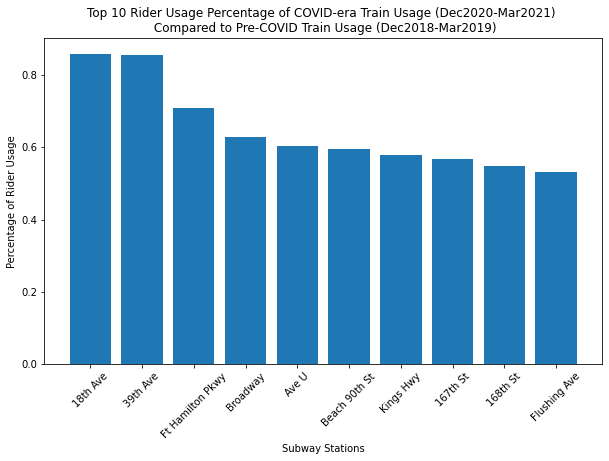

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pylab


rider_perc_df = merged_df.sort_values(['Rider_Perc'], ascending = False)
total_riders = merged_df.sort_values(['HOURLY_ENTRIES'], ascending = False)

plt.figure(figsize=(10,6))
plt.bar(x=rider_perc_df['MTA_Station'][1:11], height=rider_perc_df['Rider_Perc'][1:11])
plt.xticks(rotation = 45)
plt.ylabel('Percentage of Rider Usage')
plt.xlabel('Subway Stations')
plt.title(('Top 10 Rider Usage Percentage of COVID-era Train Usage (Dec2020-Mar2021) \n Compared to Pre-COVID Train Usage (Dec2018-Mar2019)'));
#pylab.savefig("RiderPercentage.png")


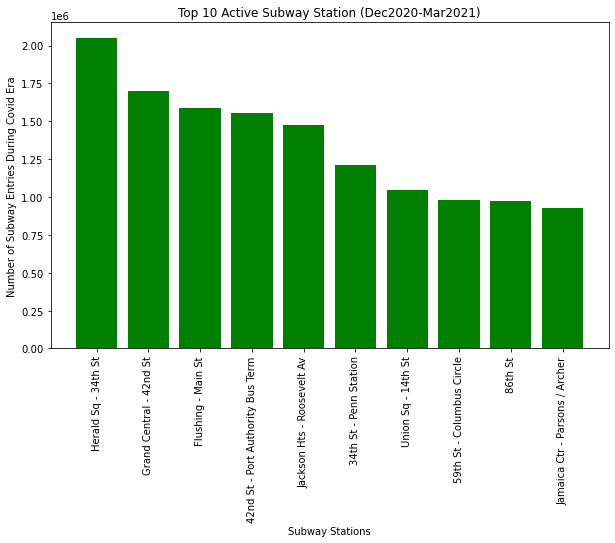

In [8]:
plt.figure(figsize=(10,6))
plt.bar(x=total_riders['MTA_Station'][:10], height=total_riders['HOURLY_ENTRIES'][:10], color='#008000')
plt.xticks(rotation = 90)
plt.ylabel('Number of Subway Entries During Covid Era')
plt.xlabel('Subway Stations')
plt.title(('Top 10 Active Subway Station (Dec2020-Mar2021)'))
pylab.savefig("COVIDEraUsage.png");


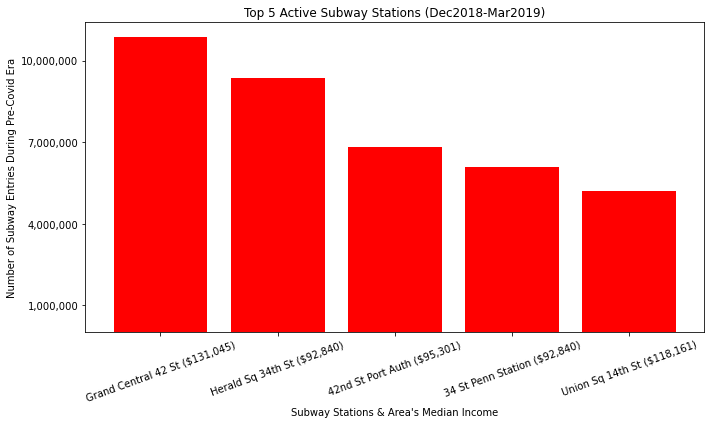

In [262]:
total_riders_pre = total_riders.sort_values(['DAILY_ENTRIES_PRECVOID'], ascending = False)

plt.figure(figsize=(10,6))
plt.bar(x=total_riders_pre['MTA_Station'][:5], height=total_riders_pre['DAILY_ENTRIES_PRECVOID'][:5], bottom = 10000, color='r')
x_values_pre = ['Grand Central 42 St ($131,045)', 'Herald Sq 34th St ($92,840)', '42nd St Port Auth ($95,301)', '34 St Penn Station ($92,840)', 'Union Sq 14th St ($118,161)']
plt.xticks(np.arange(5), labels = x_values_pre, rotation = 20)
plt.ylabel('Number of Subway Entries During Pre-Covid Era')
plt.xlabel("Subway Stations & Area's Median Income")
plt.yticks(np.arange(1000000, 12000000, 3000000), ['1,000,000', '4,000,000', '7,000,000', '10,000,000'])
plt.title(('Top 5 Active Subway Stations (Dec2018-Mar2019)'))
plt.tight_layout()
pylab.savefig("PreCovidEraUsage.png");



,MTA_Station,LINENAME,HOURLY_ENTRIES,DAILY_ENTRIES_PRECVOID,Rider_Perc
1,Grand Central - 42nd St,4567S,1701260.0,10849092.0,0.156811
0,Herald Sq - 34th St,BDFMNQRW,2051229.0,9352130.0,0.219333
3,42nd St - Port Authority Bus Term,ACENQRS1237W,1553065.0,6804760.0,0.228232
5,34th St - Penn Station,ACE,1212603.0,6059376.0,0.200120
6,Union Sq - 14th St,LNQR456W,1048984.0,5212091.0,0.201260
...,...,...,...,...,...
448,Rockaway Park - Beach 116 St,AS,20337.0,46552.0,0.436866
412,111th St,J,70307.0,44261.0,1.588464
449,Beach 98th St,AS,9827.0,31031.0,0.316683
450,Broad Channel,AS,7189.0,22178.0,0.324150


In [10]:
sql_coivd_test = """
SELECT md.*, md.DATE||" "||md.TIME as 'DateTime_ID' 
FROM mta_data md 
where 
md.STATION not in ('JOURNAL SQUARE', 'CITY / BUS', 'LACKAWANNA', 'EXCHANGE PLACE', 
'NEWARK HW BMEBE', 'JFK JAMAICA CT1', 'NEWARK BM BW', 
'NEWARK C', 'NEWARK HM HE', 'PATH NEW WTC', 'PATH WTC 2', 'RIT-ROOSEVELT', 
'GROVE STREET', 'PAVONIA/NEWPORT', 'RIT-MANHATTAN', '9TH STREET', 
'HARRISON', 'ST. GEORGE', 'THIRTY ST', 'THIRTY THIRD ST', 'TOMPKINSVILLE')
and substr(DATE,7) >= '2020';

"""

#sql QUERY 2020-2021 Data
df_covid_test = pd.read_sql(sql_coivd_test, engine)

In [11]:
graph_covid_df = mta_agg_covid_df.groupby(['MTA_Station', 'LINENAME'])['HOURLY_ENTRIES'].sum().reset_index().sort_values(['HOURLY_ENTRIES'], ascending = False)

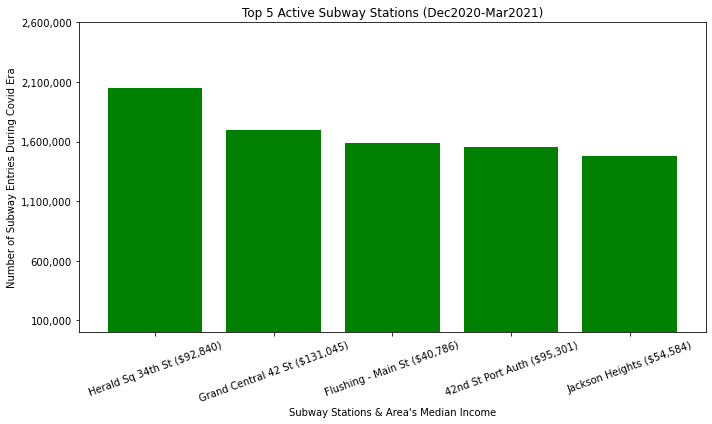

In [263]:
plt.figure(figsize=(10,6))
plt.bar(x=graph_covid_df['MTA_Station'][:5], height=graph_covid_df['HOURLY_ENTRIES'][:5], color='#008000')
x_values_covid = ['Herald Sq 34th St ($92,840)','Grand Central 42 St ($131,045)', 'Flushing - Main St ($40,786)', '42nd St Port Auth ($95,301)', 'Jackson Heights ($54,584)']
plt.xticks(np.arange(5), x_values_covid, rotation = 20)
plt.yticks(np.arange(100000, 3000000, 500000), ['100,000', '600,000', '1,100,000', '1,600,000', '2,100,000', '2,600,000'])
plt.ylabel('Number of Subway Entries During Covid Era')
plt.xlabel("Subway Stations & Area's Median Income")
plt.title(('Top 5 Active Subway Stations (Dec2020-Mar2021)'))
plt.tight_layout()
pylab.savefig("COVIDEraUsage.png");

In [13]:
##Group by these DFs for new graphs
#mta_agg_covid_df
#mta_agg_precovid_df
#mta_agg_precovid_df = mta_precovid_df.groupby(['MTA_Station','STATION', 'Date_Time_Cleaned', 'TIME', 'LINENAME', 'ZipCode', 'Median_Income', 'NTAName'])['HOURLY_ENTRIES'].apply(lambda grp: grp.sum()).reset_index()



#graph_precovid_df = graph_precovid_df.rename(columns = {'HOURLY_ENTRIES': 'DAILY_ENTRIES_PRECVOID'})
#merged_df = pd.merge(graph_covid_df, graph_precovid_df,  how='left', left_on=['MTA_Station','LINENAME'], right_on = ['MTA_Station','LINENAME'])
#merged_df['Rider_Perc'] = merged_df['HOURLY_ENTRIES']/merged_df['DAILY_ENTRIES_PRECVOID']


In [14]:
#mta_agg_covid_df
#mta_agg_precovid_df

testing_graph_covid = mta_agg_covid_df.groupby(['MTA_Station', 'LINENAME', 'ZipCode', 'Median_Income', 'NTAName'])['HOURLY_ENTRIES'].apply(lambda grp: grp.sum()).reset_index()
testing_graph_precovid = mta_agg_precovid_df.groupby(['MTA_Station', 'LINENAME', 'ZipCode', 'Median_Income', 'NTAName'])['HOURLY_ENTRIES'].apply(lambda grp: grp.sum()).reset_index()


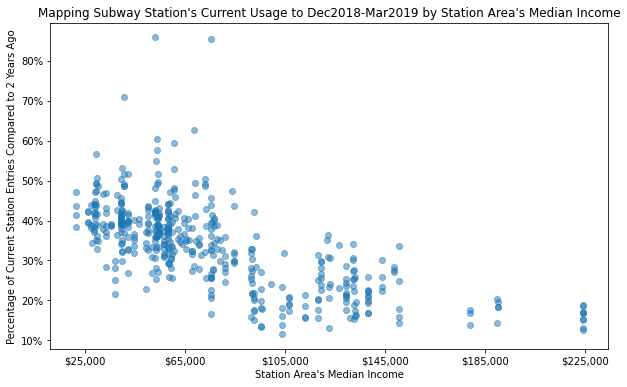

In [280]:
testing_graph_precovid = testing_graph_precovid.rename(columns = {'HOURLY_ENTRIES': 'DAILY_ENTRIES_PRECVOID'})
testing_graph_covid = testing_graph_covid.rename(columns = {'HOURLY_ENTRIES': 'DAILY_ENTRIES_COVID'})
combined_df = pd.merge(testing_graph_covid, testing_graph_precovid,  how='left', left_on=['MTA_Station','LINENAME'], right_on = ['MTA_Station','LINENAME'])
combined_df['Rider_Perc'] = combined_df['DAILY_ENTRIES_COVID']/combined_df['DAILY_ENTRIES_PRECVOID']
combined_df = combined_df.sort_values(['Rider_Perc'], ascending = False)
combined_df = combined_df[1:]


plt.figure(figsize=(10,6))
plt.scatter(combined_df['Median_Income_x'], combined_df['Rider_Perc'], alpha=0.5)
x_ticks = np.linspace(25000, 225000, 6)
values = ['$25,000', '$65,000', '$105,000', '$145,000', '$185,000', '$225,000']
plt.ylabel('Percentage of Current Station Entries Compared to 2 Years Ago')
plt.xlabel("Station Area's Median Income")
plt.xticks(x_ticks, values)
y_tickss = np.linspace(.1, .8, 8)
plt.yticks(y_tickss, ['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%'])
plt.title(("Mapping Subway Station's Current Usage to Dec2018-Mar2019 by Station Area's Median Income"))
pylab.savefig("ScatterChart_MedianIncome_ComparativeUsage.png");


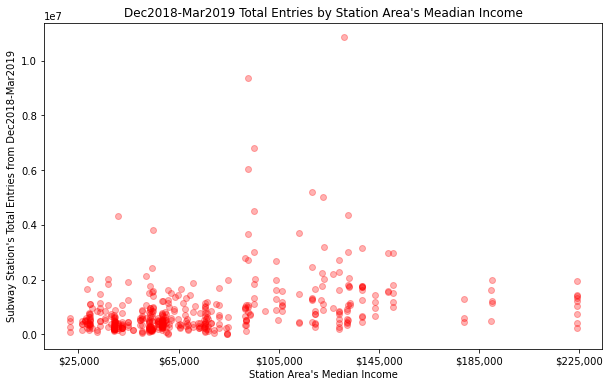

In [281]:
plt.figure(figsize=(10,6))
plt.scatter(combined_df['Median_Income_x'], combined_df['DAILY_ENTRIES_PRECVOID'], alpha=0.3, color='r')
x_ticks = np.linspace(25000, 225000, 6)
values = ['$25,000', '$65,000', '$105,000', '$145,000', '$185,000', '$225,000']
plt.ylabel("Subway Station's Total Entries from Dec2018-Mar2019")
plt.xlabel("Station Area's Median Income")
plt.xticks(x_ticks, values)
plt.title(("Dec2018-Mar2019 Total Entries by Station Area's Meadian Income"))
pylab.savefig("ScatterChart_MedianIncome_PreCovidUsage.png");




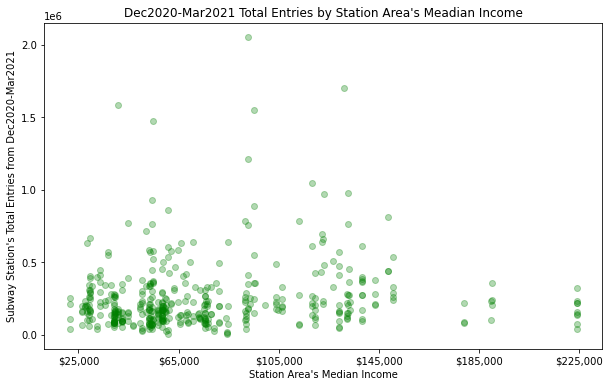

In [279]:
plt.figure(figsize=(10,6))
plt.scatter(combined_df['Median_Income_x'], combined_df['DAILY_ENTRIES_COVID'], alpha=0.3, color='#008000')
x_ticks = np.linspace(25000, 225000, 6)
values = ['$25,000', '$65,000', '$105,000', '$145,000', '$185,000', '$225,000']
plt.ylabel("Subway Station's Total Entries from Dec2020-Mar2021" )
plt.xlabel("Station Area's Median Income")
plt.xticks(x_ticks, values)
plt.title(("Dec2020-Mar2021 Total Entries by Station Area's Meadian Income"))
pylab.savefig("ScatterChart_MedianIncome_CovidUsage.png");



In [255]:
neighorhood_covid = mta_agg_covid_df.groupby(['NTAName'])['HOURLY_ENTRIES'].sum().reset_index()
neighorhood_precovid = mta_agg_precovid_df.groupby(['NTAName'])['HOURLY_ENTRIES'].sum().reset_index()
neighorhood_precovid = neighorhood_precovid.rename(columns = {'HOURLY_ENTRIES': 'Entries_PreCovid'})
neighorhood_covid = neighorhood_covid.rename(columns = {'HOURLY_ENTRIES': 'Entries_Current'})

sql_boro = """
select DISTINCT nyc_neighorhood_profile.NTAName, nyc_neighorhood_profile.BoroName
from mta_data
join  nyc_neighorhood_profile on
    mta_data.STATION = nyc_neighorhood_profile.MTA_TurnStile_Station_ID
    and mta_data.LINENAME = nyc_neighorhood_profile.MTA_Turnstile_Linename_ID
where mta_data.STATION not in 
    (
    'JOURNAL SQUARE', 'CITY / BUS', 'LACKAWANNA', 'EXCHANGE PLACE', 
    'NEWARK HW BMEBE', 'JFK JAMAICA CT1', 'NEWARK BM BW', 
    'NEWARK C', 'NEWARK HM HE', 'PATH NEW WTC', 'PATH WTC 2', 'RIT-ROOSEVELT', 
    'GROVE STREET', 'PAVONIA/NEWPORT', 'RIT-MANHATTAN', '9TH STREET', 
    'HARRISON', 'ST. GEORGE', 'THIRTY ST', 'THIRTY THIRD ST', 'TOMPKINSVILLE'
    )
"""

boro_df = pd.read_sql(sql_boro, engine)

combined_df_neigh = pd.merge(neighorhood_covid, neighorhood_precovid,  how='left', left_on=['NTAName'], right_on = ['NTAName'])
combined_df_neigh['Return_to_Normal_Percentage'] = round(combined_df_neigh['Entries_Current']/combined_df_neigh['Entries_PreCovid'], 2)
combined_df_neigh = combined_df_neigh.sort_values(['Return_to_Normal_Percentage'], ascending = False)
combined_df_neigh = pd.merge(combined_df_neigh, boro_df, how='left', left_on=['NTAName'], right_on = ['NTAName'])
combined_df_neigh = combined_df_neigh.rename(columns = {'NTAName': 'Neighorhood Name'})
#combined_df = combined_df[1:]

combined_df_neigh.head(50)
#plt.scatter(combined_df_neigh['Median_Income_x'], combined_df_neigh['DAILY_ENTRIES_PRECVOID'], alpha=0.2)


,Neighorhood Name,Entries_Current,Entries_PreCovid,Return_to_Normal_Percentage,BoroName
0,Richmond Hill,233655.0,386563.0,0.60,Queens
1,Borough Park,454667.0,838559.0,0.54,Brooklyn
2,North Corona,1204759.0,2396372.0,0.50,Queens
3,Woodhaven,389651.0,789230.0,0.49,Queens
4,Jackson Heights,1139264.0,2379487.0,0.48,Queens
5,West Farms-Bronx River,228476.0,487069.0,0.47,Bronx
6,West Brighton,458720.0,1009759.0,0.45,Brooklyn
7,West Concourse,1491831.0,3338077.0,0.45,Bronx
8,Fordham South,356742.0,800243.0,0.45,Bronx
9,Bensonhurst East,619220.0,1374120.0,0.45,Brooklyn


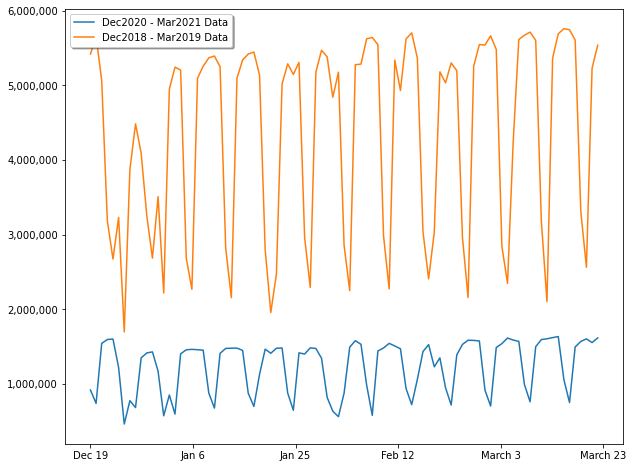

In [247]:
date_covid = mta_covid_df.groupby(['DATE'])['HOURLY_ENTRIES'].sum().reset_index()
date_covid = date_covid.rename(columns = {'HOURLY_ENTRIES': 'DAILY_ENTRIES_COVID'})
date_covid['DATE'] = pd.to_datetime(date_covid['DATE'], format='%m/%d/%Y')
date_covid = date_covid.sort_values(['DATE'], ascending = True)

date_covid['Month'] = date_covid['DATE'].dt.month
date_covid['Day'] = date_covid['DATE'].dt.day
date_covid['Month_Day'] = date_covid['Month'].apply(str) + '-' + date_covid['Day'].apply(str)



date_precovid = mta_precovid_df.groupby(['DATE'])['HOURLY_ENTRIES'].sum().reset_index()
date_precovid = date_precovid.rename(columns = {'HOURLY_ENTRIES': 'DAILY_ENTRIES_PRECVOID'})
date_precovid['DATE'] = pd.to_datetime(date_precovid['DATE'], format='%m/%d/%Y')
date_precovid = date_precovid.sort_values(['DATE'], ascending = True)

date_precovid['Month'] = date_precovid['DATE'].dt.month
date_precovid['Day'] = date_precovid['DATE'].dt.day
date_precovid['Month_Day'] = date_precovid['Month'].apply(str) + '-' + date_precovid['Day'].apply(str)

plt.figure(figsize=(10,8))
plt.plot(date_covid['Month_Day'], date_covid['DAILY_ENTRIES_COVID'])
plt.plot(date_precovid['Month_Day'], date_precovid['DAILY_ENTRIES_PRECVOID'])
x_ticks = np.linspace(0, 91, 6)
x_values = ['Dec 19', 'Jan 6', 'Jan 25', 'Feb 12', 'March 3', 'March 23'];
y_values = ['1,000,000', '2,000,000', '3,000,000', '4,000,000', '5,000,000', '6,000,000']
plt.xticks(x_ticks, x_values)
y_ticks = np.linspace(1000000, 6000000, 6)
plt.yticks(y_ticks, y_values)
plt.legend(['Dec2020 - Mar2021 Data','Dec2018 - Mar2019 Data'],shadow = True, loc = 0)
pylab.savefig("TimeFrameCompare_LineChart.png");


In [169]:
neighorhood = """with cte_neighorhood as 
(
select NTAname, Median_income
from mta_data
 join  nyc_neighorhood_profile on
mta_data.STATION = nyc_neighorhood_profile.MTA_TurnStile_Station_ID
and mta_data.LINENAME = nyc_neighorhood_profile.MTA_Turnstile_Linename_ID
where mta_data.STATION not in 
    (
    'JOURNAL SQUARE', 'CITY / BUS', 'LACKAWANNA', 'EXCHANGE PLACE', 
    'NEWARK HW BMEBE', 'JFK JAMAICA CT1', 'NEWARK BM BW', 
    'NEWARK C', 'NEWARK HM HE', 'PATH NEW WTC', 'PATH WTC 2', 'RIT-ROOSEVELT', 
    'GROVE STREET', 'PAVONIA/NEWPORT', 'RIT-MANHATTAN', '9TH STREET', 
    'HARRISON', 'ST. GEORGE', 'THIRTY ST', 'THIRTY THIRD ST', 'TOMPKINSVILLE'
    )
)
select NTAName, round(avg(median_income)) as Neighorhood_Median_Income
from cte_neighorhood
group by NTAname;"""

neighorhood_df = pd.read_sql(neighorhood, engine)

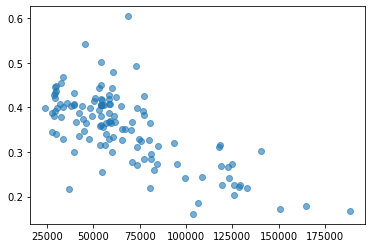

In [181]:
neighorhood_covid = mta_agg_covid_df.groupby(['NTAName'])['HOURLY_ENTRIES'].sum().reset_index()
neighorhood_precovid = mta_agg_precovid_df.groupby(['NTAName'])['HOURLY_ENTRIES'].sum().reset_index()
neighorhood_precovid = neighorhood_precovid.rename(columns = {'HOURLY_ENTRIES': 'DAILY_ENTRIES_PRECVOID'})
neighorhood_covid = neighorhood_covid.rename(columns = {'HOURLY_ENTRIES': 'DAILY_ENTRIES_COVID'})


combined_df_neigh = pd.merge(neighorhood_covid, neighorhood_precovid,  how='left', left_on=['NTAName'], right_on = ['NTAName'])
combined_df_neigh['Rider_Perc'] = combined_df_neigh['DAILY_ENTRIES_COVID']/combined_df_neigh['DAILY_ENTRIES_PRECVOID']
combined_df_neigh = combined_df_neigh.sort_values(['Rider_Perc'], ascending = False)
#combined_df = combined_df[1:]

combined_df_neigh = pd.merge(combined_df_neigh, neighorhood_df, how='left', left_on=['NTAName'], right_on = ['NTAname'])
combined_df_neigh
plt.scatter(combined_df_neigh['Neighorhood_Median_Income'], combined_df_neigh['Rider_Perc'], alpha=.6)


,NTAname,Neighorhood_Median_Income
0,Airport,75471.0
1,Allerton-Pelham Gardens,65399.0
2,Astoria,74569.0
3,Battery Park City-Lower Manhattan,188246.0
4,Bay Ridge,70580.0
...,...,...
118,Woodlawn-Wakefield,60192.0
119,Woodside,58948.0
120,Yorkville,122969.0
121,park-cemetery-etc-Brooklyn,77171.0


In [182]:
import seaborn as sns

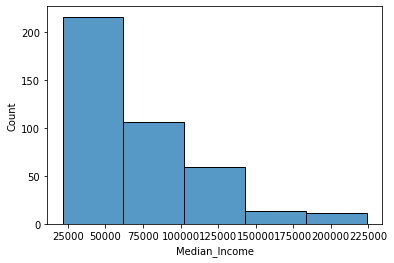

In [198]:
sql_stations = """
select DISTINCT nyc_neighorhood_profile.MTA_Station, Median_income
from mta_data
join  nyc_neighorhood_profile on
    mta_data.STATION = nyc_neighorhood_profile.MTA_TurnStile_Station_ID
    and mta_data.LINENAME = nyc_neighorhood_profile.MTA_Turnstile_Linename_ID
where mta_data.STATION not in 
    (
    'JOURNAL SQUARE', 'CITY / BUS', 'LACKAWANNA', 'EXCHANGE PLACE', 
    'NEWARK HW BMEBE', 'JFK JAMAICA CT1', 'NEWARK BM BW', 
    'NEWARK C', 'NEWARK HM HE', 'PATH NEW WTC', 'PATH WTC 2', 'RIT-ROOSEVELT', 
    'GROVE STREET', 'PAVONIA/NEWPORT', 'RIT-MANHATTAN', '9TH STREET', 
    'HARRISON', 'ST. GEORGE', 'THIRTY ST', 'THIRTY THIRD ST', 'TOMPKINSVILLE'
    )

"""
stations_df = pd.read_sql(sql_stations, engine)

station_graph = sns.histplot(stations_df['Median_Income'], kde=False,bins=5);